In [1]:
# Import TF and check for GPU

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

# Import required libraries

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import layers
from tf.keras.models import save_model, load_model
import math
from sklearn.model_selection import train_test_split
import sys
import random 


2023-09-12 14:33:23.928205: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-12 14:33:24.831915: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/abraham/miniconda3/envs/tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.12.1


In [2]:
# 1. Load Dataset
## Load Train Set
train_shape_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/shape_npy/shape_filled5.npy'
train_lc_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/lc_npy/lc_dict_5.npy'
train_lc = np.load(train_lc_dir)
train_shape = np.load(train_shape_dir)
# Check equality of number of dataset
if len(train_lc)==len(train_shape):
    print("Train Set: No. of LC = No. of shapes")
else:
    sys.exit("EXIT: Train Set: No. of LC != No. of shapes")

## Load Validation Set
vald_shape_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/shape_npy/shape_filled4.npy'
vald_lc_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/lc_npy/lc_dict_4.npy'
vald_lc = np.load(vald_lc_dir)
vald_shape = np.load(vald_shape_dir)
# Check equality of number of dataset
if len(vald_lc)==len(vald_shape):
    print("Vald Set: No. of LC = No. of shapes")
else:
    sys.exit("Vald Set: No. of LC = No. of shapes")

Train Set: No. of LC = No. of shapes
Vald Set: No. of LC = No. of shapes


In [3]:
# 2. Normalize the image, convert to opacity map
## Train Set
train_shape = train_shape/np.amax(train_shape)
train_shape_where_0 = np.where(train_shape == 0)
train_shape_where_1 = np.where(train_shape == 1)
train_shape[train_shape_where_0] = 1  # 1 represent the shape (1 opacity)
train_shape[train_shape_where_1] = 0  # 0 represent background (0 opacity)

## Valdn Set
vald_shape = vald_shape/np.amax(vald_shape)
vald_shape_where_0 = np.where(vald_shape == 0)
vald_shape_where_1 = np.where(vald_shape == 1)
vald_shape[vald_shape_where_0] = 1  # 1 represent the shape (1 opacity)
vald_shape[vald_shape_where_1] = 0  # 0 represent background (0 opacity)
print("Normalized the shape")

Normalized the shape


In [4]:
# 2. Normalize the lightcurves
## - Train Set
train_lc_scaled = np.zeros(train_lc.shape)
for i in np.arange(len(train_lc_scaled)):
    train_lc_scaled[i] = (train_lc[i] - np.amin(train_lc[i]))/(np.amax(train_lc[i]) - np.amin(train_lc[i]))

## - Vald Set
vald_lc_scaled = np.zeros(vald_lc.shape)
for i in np.arange(len(vald_lc_scaled)):
    vald_lc_scaled[i] = (vald_lc[i] - np.amin(vald_lc[i]))/(np.amax(vald_lc[i]) - np.amin(vald_lc[i]))
print("Normalized the light curves")

# del train_lc
# del vald_lc

Normalized the light curves


In [5]:
# Add flat line towards left and right of dip
# 50 data points on each side
# 3. Extend the lightcurves
## - Train Set
train_lc_scaled_append = np.ones((train_lc.shape[0],200))
print('train_lc_scaled_append.shape = ',train_lc_scaled_append.shape)
print("len(train_lc_scaled_append[0,50:150]) = ",len(train_lc_scaled_append[0,50:150]))

for i in np.arange(len(train_lc_scaled)):
    train_lc_scaled_append[i,50:150] = train_lc_scaled[i]

## - Vald Set
vald_lc_scaled_append = np.ones((vald_lc.shape[0],200))
for i in np.arange(len(vald_lc_scaled)):
    vald_lc_scaled_append[i,50:150] = vald_lc_scaled[i]
print("Extended the light curves")

train_lc_scaled_append.shape =  (132136, 200)
len(train_lc_scaled_append[0,50:150]) =  100
Extended the light curves


In [6]:
# Add Gaussian noise 
# del variable - train and vald
del train_lc_scaled
del vald_lc_scaled
train_lc_scaled = train_lc_scaled_append
vald_lc_scaled = vald_lc_scaled_append
del train_lc_scaled_append
del vald_lc_scaled_append


num_train_lc_scaled =  132136
array_length =  200
(132136, 200)


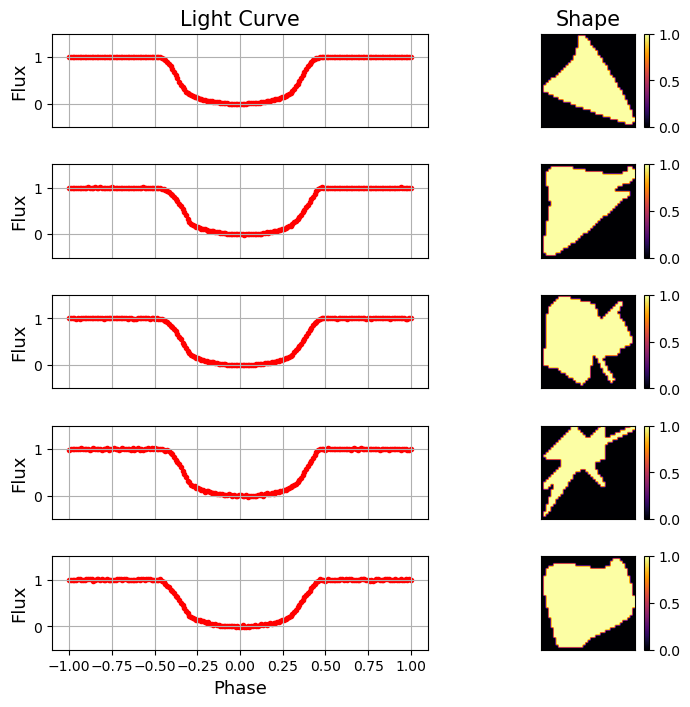

In [7]:
# Add Gaussian noise - train light curves
# No. of lcs

num_train_lc_scaled = len(train_lc_scaled)
print('num_train_lc_scaled = ',num_train_lc_scaled)

# Length of each 1D array
array_length = len(train_lc_scaled[0])
print('array_length = ',array_length)

# Generate random standard deviations following a uniform distribution
# Same for validation also
std_dev_lower = 10**(-3)
std_dev_upper = 10**(-2)
std_devs_train = np.random.uniform(std_dev_lower, std_dev_upper, num_train_lc_scaled)
SNRs_train  = 1/std_devs_train

# SNRs_train  = np.random.uniform(10, 1000, num_train_lc_scaled)
# std_devs_train = 1/SNRs_train

# Initialize an empty list to store the noisy arrays
noisy_arrays = []

# Generate and add Gaussian noise to each 1D array
for std_dev in std_devs_train:
    mean = 0
    noise = np.random.normal(mean, std_dev, array_length)
    noisy_arrays.append(noise)

# Convert the list of noisy arrays to a NumPy array
noisy_arrays = np.array(noisy_arrays)
print(noisy_arrays.shape)

train_lc_scaled_noise = np.zeros(train_lc_scaled.shape)

for i in np.arange(len(train_lc_scaled)):
    train_lc_scaled_noise[i] = train_lc_scaled[i] + noisy_arrays[i]

# Plot - Train LCs
num = 5
fig,ax=plt.subplots(num,2, figsize=(8,8), gridspec_kw={ 'width_ratios': [2,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Shape',size=15)
ax[0][0].set_title('Light Curve',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1,1,len(train_lc_scaled_noise[0]))
# advance = 60

i = 0
for i in np.arange(0,num):
    k = random.randint(0, len(vald_lc_scaled)-1)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(train_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
    ax[i][0].scatter(ph, train_lc_scaled_noise[k],color = 'red',marker='.')
    ax[i][0].grid('on')
    i = i + 1

len(SNRs_calc_train)) =  132136


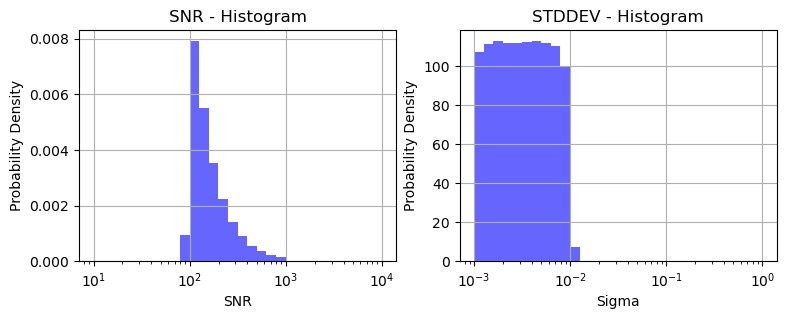

In [8]:
# Plot Histogram of SNR and standard deviations
## Train LCs
std_devs_calc_train = np.array([np.std(arr) for arr in noisy_arrays])
SNRs_calc_train = 1/std_devs_calc_train
print('len(SNRs_calc_train)) = ',len(SNRs_calc_train))


plt.figure(figsize=(9, 3))

plt.subplot(121)
bins = np.logspace(1,4,31)
plt.hist(SNRs_calc_train, bins=bins, density=True, alpha=0.6, color='b')
plt.xlabel('SNR')
plt.xscale("log")
plt.ylabel('Probability Density')
plt.title('SNR - Histogram')
plt.grid(True)

plt.subplot(122)
bins = np.logspace(-3,0,31)
plt.hist(std_devs_calc_train, bins=bins, density=True, alpha=0.6, color='b')
plt.xlabel('Sigma')
plt.xscale("log")
plt.ylabel('Probability Density')
plt.title('STDDEV - Histogram')
plt.grid(True)

plt.show()

num_vald_lc_scaled =  1000
array_length =  200
(1000, 200)


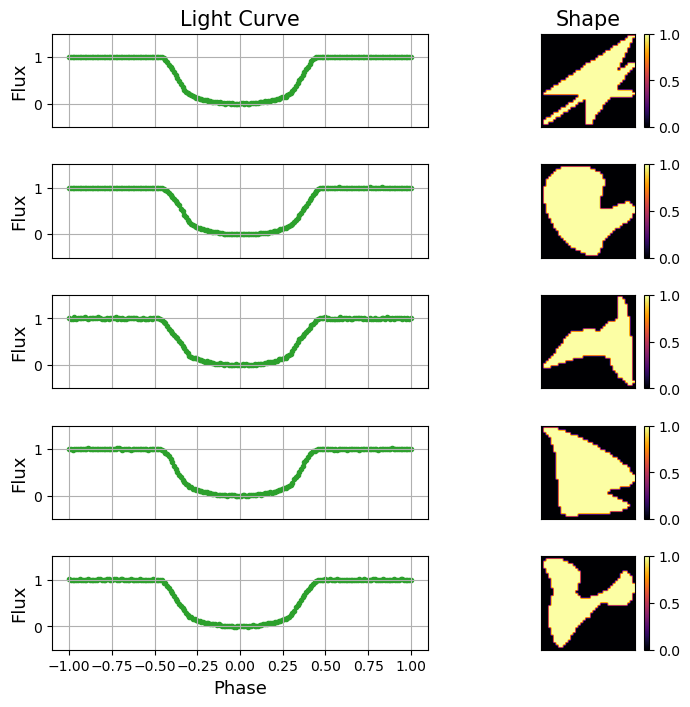

In [9]:
# Add Gaussian noise - vald light curves
# No. of lcs
num_vald_lc_scaled = len(vald_lc_scaled)
print('num_vald_lc_scaled = ',num_vald_lc_scaled)

# Length of each 1D array
array_length = len(vald_lc_scaled[0])
print('array_length = ',array_length)

# Generate random standard deviations following a uniform distribution
std_devs_vald = np.random.uniform(std_dev_lower, std_dev_upper, num_vald_lc_scaled)
SNRs_vald  = 1/std_devs_vald

# SNRs_vald  = np.random.uniform(10, 1000, num_vald_lc_scaled)
# std_devs_vald = 1/SNRs_vald

# Initialize an empty list to store the noisy arrays
noisy_arrays = []

# Generate and add Gaussian noise to each 1D array
for std_dev in std_devs_vald:
    mean = 0
    noise = np.random.normal(mean, std_dev, array_length)
    noisy_arrays.append(noise)

# Convert the list of noisy arrays to a NumPy array
noisy_arrays = np.array(noisy_arrays)
print(noisy_arrays.shape)

vald_lc_scaled_noise = np.zeros(vald_lc_scaled.shape)

for i in np.arange(len(vald_lc_scaled)):
    vald_lc_scaled_noise[i] = vald_lc_scaled[i] + noisy_arrays[i]


# Plot - Vald LCs
num = 5
fig,ax=plt.subplots(num,2, figsize=(8,8), gridspec_kw={ 'width_ratios': [2,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Shape',size=15)
ax[0][0].set_title('Light Curve',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1,1,len(vald_lc_scaled_noise[0]))
# advance = 60

i = 0
for i in np.arange(0,num):
    k = random.randint(0, len(vald_lc_scaled)-1)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(train_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
    ax[i][0].scatter(ph, vald_lc_scaled_noise[k],color = 'tab:green',marker='.')
    ax[i][0].grid('on')
    i = i + 1

len(SNRs_calc_train)) =  1000


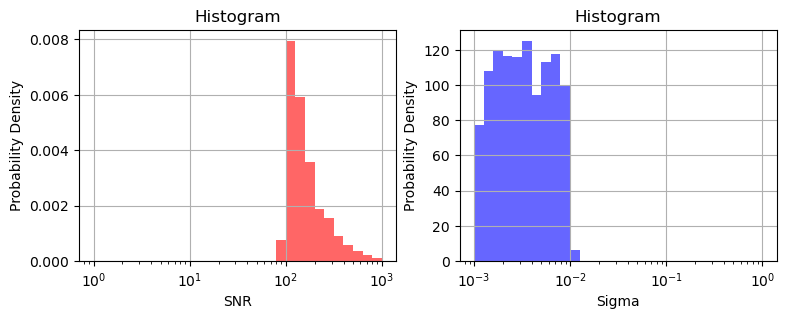

In [10]:
# Plot Histogram of SNR and standard deviations
## Valdn LCs
std_devs_calc_train = np.array([np.std(arr) for arr in noisy_arrays])
SNRs_calc_train = 1/std_devs_calc_train
print('len(SNRs_calc_train)) = ',len(SNRs_calc_train))


plt.figure(figsize=(9, 3))

plt.subplot(121)
bins = np.logspace(0,3,31)
plt.hist(SNRs_calc_train, bins=bins, density=True, alpha=0.6, color='r')
plt.xlabel('SNR')
plt.xscale("log")
plt.ylabel('Probability Density')
plt.title('Histogram')
plt.grid(True)

plt.subplot(122)
bins = np.logspace(-3,0,31)
plt.hist(std_devs_calc_train, bins=bins, density=True, alpha=0.6, color='b')
plt.xlabel('Sigma')
plt.xscale("log")
plt.ylabel('Probability Density')
plt.title('Histogram')
plt.grid(True)

plt.show()

In [11]:
print(train_lc_scaled_noise.shape)
concat_train_lc = np.concatenate((train_lc_scaled_noise,train_lc_scaled))
print('concat_train_lc = ',concat_train_lc.shape)

print(train_shape.shape)
concat_train_shape = np.concatenate((train_shape,train_shape))
print('concat_train_shape = ',concat_train_shape.shape)

print(vald_lc_scaled_noise.shape)
concat_vald_lc = np.concatenate((vald_lc_scaled_noise,vald_lc_scaled))
print('concat_vald_lc = ',concat_vald_lc.shape)

print(vald_shape.shape)
concat_vald_shape = np.concatenate((vald_shape,vald_shape))
print('concat_vald_shape = ',concat_vald_shape.shape)

(132136, 200)
concat_train_lc =  (264272, 200)
(132136, 38, 38)
concat_train_shape =  (264272, 38, 38)
(1000, 200)
concat_vald_lc =  (2000, 200)
(1000, 38, 38)
concat_vald_shape =  (2000, 38, 38)


In [12]:
# ML Pipeline
## Train Set
# train_dataset = tf.data.Dataset.from_tensor_slices((concat_train_lc,concat_train_shape))
train_dataset = tf.data.Dataset.from_tensor_slices((train_lc_scaled_noise,train_shape))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(len(train_dataset))
train_dataset = train_dataset.batch(100)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
print(train_dataset)

## Vald Set
# vald_dataset = tf.data.Dataset.from_tensor_slices((concat_vald_lc,concat_vald_shape))
vald_dataset = tf.data.Dataset.from_tensor_slices((vald_lc_scaled_noise,vald_shape))
vald_dataset = vald_dataset.batch(100)
vald_dataset = vald_dataset.cache()
vald_dataset = vald_dataset.prefetch(tf.data.AUTOTUNE)

print(vald_dataset)

2023-09-12 14:33:58.372866: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30931 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 200), dtype=tf.float64, name=None), TensorSpec(shape=(None, 38, 38), dtype=tf.float64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 200), dtype=tf.float64, name=None), TensorSpec(shape=(None, 38, 38), dtype=tf.float64, name=None))>


In [13]:
# CNN Model
input_shape = np.array(np.shape(train_lc_scaled[0]))
print("np.shape(input_shape) = ",input_shape[0])

output_shape = np.array(np.shape(train_shape[0]))
print("np.shape(input_shape) = ",output_shape[0],output_shape[1])

START = input_shape[0] # 94 #
END = output_shape[0] # 38  # pixel size along one axis
print("Start = ",START)
print("End = ",END)

conv_ip = keras.layers.Input(shape=(START,),name='Input')
x= keras.layers.Reshape((START, 1), input_shape=(START,),name='reshape_1')(conv_ip)
x= keras.layers.BatchNormalization()(x)

x=keras.layers.Conv1D(16,kernel_size=5,strides=1,activation='relu',name='conv16_5', padding='same')(x)
x=keras.layers.Conv1D(16,kernel_size=5,strides=1,activation='relu',name='second_conv16_5', padding='same')(x)
x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_1', padding='same')(x) #400

x=keras.layers.Conv1D(32,kernel_size=5,strides=1,activation='relu',name='first_conv32_5', padding='same')(x)
x=keras.layers.Conv1D(32,kernel_size=5,strides=1,activation='relu',name='second_conv32_5', padding='same')(x)
x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_2', padding='same')(x) #200

x=keras.layers.Conv1D(64,kernel_size=5,strides=1,activation='relu',name='first_conv64_5', padding='same')(x)
x=keras.layers.Conv1D(64,kernel_size=5,strides=1,activation='relu',name='second_conv64_5', padding='same')(x)
x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_3', padding='same')(x) #100

x=keras.layers.Flatten(name='flat_1')(x)

x2=keras.layers.Dense(256,name='dense_layer_5',activation='relu')(x)
x2=keras.layers.Dense(256,name='dense_layer_6',activation='relu')(x2)

x2= keras.layers.Dense(END**2,name='dense_layer_u',activation='relu')(x2)
x2 = keras.layers.Reshape(target_shape=(END, END, 1),name='reshape_2')(x2)

x2=keras.layers.Conv2D(32,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_52', padding='same')(x2)
x2=keras.layers.Conv2D(32,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_522', padding='same')(x2)
x2=keras.layers.Conv2D(16,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_524', padding='same')(x2)
x2=keras.layers.Conv2D(1,kernel_size=3,strides=1,activation='relu',name='second_conv64_53', padding='same')(x2)
conv_op = keras.layers.Reshape(target_shape=(END, END),name='reshape_3')(x2)
model = keras.Model(inputs=conv_ip, outputs=conv_op, name="predict_shape_from_LC")
model.summary()
print("Model is defined")

np.shape(input_shape) =  200
np.shape(input_shape) =  38 38
Start =  200
End =  38
Model: "predict_shape_from_LC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 200)]             0         
                                                                 
 reshape_1 (Reshape)         (None, 200, 1)            0         
                                                                 
 batch_normalization (BatchN  (None, 200, 1)           4         
 ormalization)                                                   
                                                                 
 conv16_5 (Conv1D)           (None, 200, 16)           96        
                                                                 
 second_conv16_5 (Conv1D)    (None, 200, 16)           1296      
                                                                 
 maxpool_1 (MaxPooling1D)   

In [14]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='mse')
print("Model is compiled")

#Patience early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
print("Early stopping defined")

#Learning rate scheduler
def step_decay(epoch):
	initial_lrate = 0.001
	drop = 0.5
	epochs_drop = 20
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate
lr_sched = keras.callbacks.LearningRateScheduler(step_decay)
print("Learning rate scheduler defined")

Model is compiled
Early stopping defined
Learning rate scheduler defined


In [15]:
# Training 
print("Training will start now")
# history = model.fit(train_lc_scaled, train_shape, epochs=2000,verbose=2, validation_data=(vald_lc_scaled,vald_shape),callbacks=[es,lr_sched])
history = model.fit(train_dataset, epochs=2000,verbose=2, validation_data=vald_dataset,callbacks=[es,lr_sched])

# Save Model
save_model(model, "ml_saved_models/model_sep12_noise/model_sep12_v2_noise_lc.h5")

Training will start now
Epoch 1/2000


2023-09-12 14:34:05.461103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [132136,200]
	 [[{{node Placeholder/_0}}]]
2023-09-12 14:34:05.461619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [132136,38,38]
	 [[{{node Placeholder/_1}}]]
2023-09-12 14:34:09.624449: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-09-12 14:34:12.322813: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f4bf37732a0 initialized for platform CUDA (this does not guarantee that XLA will be use

1322/1322 - 39s - loss: 0.1545 - val_loss: 0.1409 - lr: 0.0010 - 39s/epoch - 30ms/step
Epoch 2/2000
1322/1322 - 21s - loss: 0.1357 - val_loss: 0.1328 - lr: 0.0010 - 21s/epoch - 16ms/step
Epoch 3/2000
1322/1322 - 21s - loss: 0.1315 - val_loss: 0.1331 - lr: 0.0010 - 21s/epoch - 16ms/step
Epoch 4/2000
1322/1322 - 22s - loss: 0.1297 - val_loss: 0.1274 - lr: 0.0010 - 22s/epoch - 16ms/step
Epoch 5/2000
1322/1322 - 21s - loss: 0.1284 - val_loss: 0.1266 - lr: 0.0010 - 21s/epoch - 16ms/step
Epoch 6/2000
1322/1322 - 21s - loss: 0.1276 - val_loss: 0.1267 - lr: 0.0010 - 21s/epoch - 16ms/step
Epoch 7/2000
1322/1322 - 21s - loss: 0.1267 - val_loss: 0.1248 - lr: 0.0010 - 21s/epoch - 16ms/step
Epoch 8/2000
1322/1322 - 20s - loss: 0.1262 - val_loss: 0.1237 - lr: 0.0010 - 20s/epoch - 15ms/step
Epoch 9/2000
1322/1322 - 20s - loss: 0.1258 - val_loss: 0.1244 - lr: 0.0010 - 20s/epoch - 15ms/step
Epoch 10/2000
1322/1322 - 21s - loss: 0.1256 - val_loss: 0.1259 - lr: 0.0010 - 21s/epoch - 16ms/step
Epoch 11/200

In [23]:
# Validation dataset - Prediciton
model_load = load_model("ml_saved_models/model_sep12_noise/model_sep12_v2_noise_lc.h5")
vald_predict_shape = model_load.predict(vald_lc_scaled_noise)


32/32 [==============================] - 0s 6ms/step


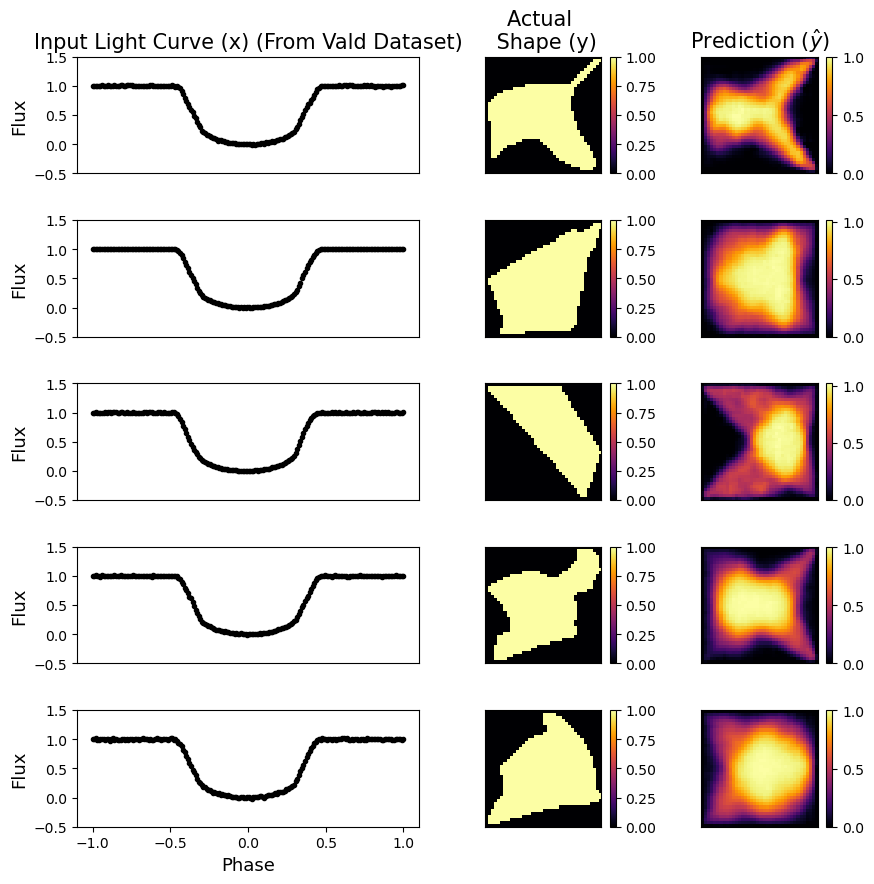

In [24]:

num = 5
fig,ax=plt.subplots(num,3, figsize=(10,10), gridspec_kw={ 'width_ratios': [2,1,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Actual \n Shape (y)',size=15)
ax[0][0].set_title('Input Light Curve (x) (From Vald Dataset)',size=15)
ax[0][2].set_title(r'Prediction ($\hat{y}$)',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1.0,1.0,len(vald_lc_scaled_noise[0]))
# advance = 60
for i in range(num):
    k = random.randint(0, len(vald_lc_scaled_noise)-1)
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(vald_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
    ax[i][0].scatter(ph, vald_lc_scaled_noise[k],color = 'black',marker='.')
    img = ax[i][2].imshow(vald_predict_shape[k],cmap='inferno')
    plt.colorbar(img)

In [25]:
# Load the test Dataset
test_shape_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/shape_npy/shape_filled8.npy'
test_lc_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/lc_npy/lc_dict_8.npy'
test_lc = np.load(test_lc_dir)
test_shape = np.load(test_shape_dir)
# Check equality of number of dataset
if len(test_lc)==len(test_shape):
    print("test Set: No. of LC = No. of shapes")
else:
    sys.exit("EXIT: testn Set: No. of LC != No. of shapes")

# Normalize the image, convert to opacity map
## Test Set
test_shape = test_shape/np.amax(test_shape)
test_shape_where_0 = np.where(test_shape == 0)
test_shape_where_1 = np.where(test_shape == 1)
test_shape[test_shape_where_0] = 1  # 1 represent the shape (1 opacity)
test_shape[test_shape_where_1] = 0  # 0 represent background (0 opacity)


# Normalize the lightcurves
## - Test Set
test_lc_scaled = np.zeros(test_lc.shape)
for i in np.arange(len(test_lc_scaled)):
    test_lc_scaled[i] = (test_lc[i] - np.amin(test_lc[i]))/(np.amax(test_lc[i]) - np.amin(test_lc[i]))



# ---
# Extend lc here
## - Test Set Extend the light curve
test_lc_scaled_append = np.ones((test_lc.shape[0],200))
for i in np.arange(len(test_lc_scaled)):
    test_lc_scaled_append[i,50:150] = test_lc_scaled[i]
print("Extended the light curves")

del test_lc_scaled
test_lc_scaled = test_lc_scaled_append
del test_lc_scaled_append

# ---
# Add noise
# Add Gaussian noise - vald light curves
# No. of lcs
num_test_lc_scaled = len(test_lc_scaled)
print('num_test_lc_scaled = ',num_test_lc_scaled)

# Length of each 1D array
array_length = len(test_lc_scaled[0])
print('array_length = ',array_length)

# Generate random standard deviations following a uniform distribution
std_devs_test = np.random.uniform(std_dev_lower, std_dev_upper, num_test_lc_scaled)
SNRs_test  = 1/std_devs_test

# Initialize an empty list to store the noisy arrays
noisy_arrays_test = []

# Generate and add Gaussian noise to each 1D array
for std_dev in std_devs_test:
    mean = 0
    noise = np.random.normal(mean, std_dev, array_length)
    noisy_arrays_test.append(noise)

# Convert the list of noisy arrays to a NumPy array
noisy_arrays_test = np.array(noisy_arrays_test)
print(noisy_arrays_test.shape)

test_lc_scaled_noise = np.zeros(test_lc_scaled.shape)

for i in np.arange(len(test_lc_scaled)):
    test_lc_scaled_noise[i] = test_lc_scaled[i] + noisy_arrays_test[i]

test_predict_shape = model_load.predict(test_lc_scaled_noise)

test Set: No. of LC = No. of shapes
Extended the light curves
num_test_lc_scaled =  250
array_length =  200
(250, 200)
8/8 [==============================] - 0s 5ms/step


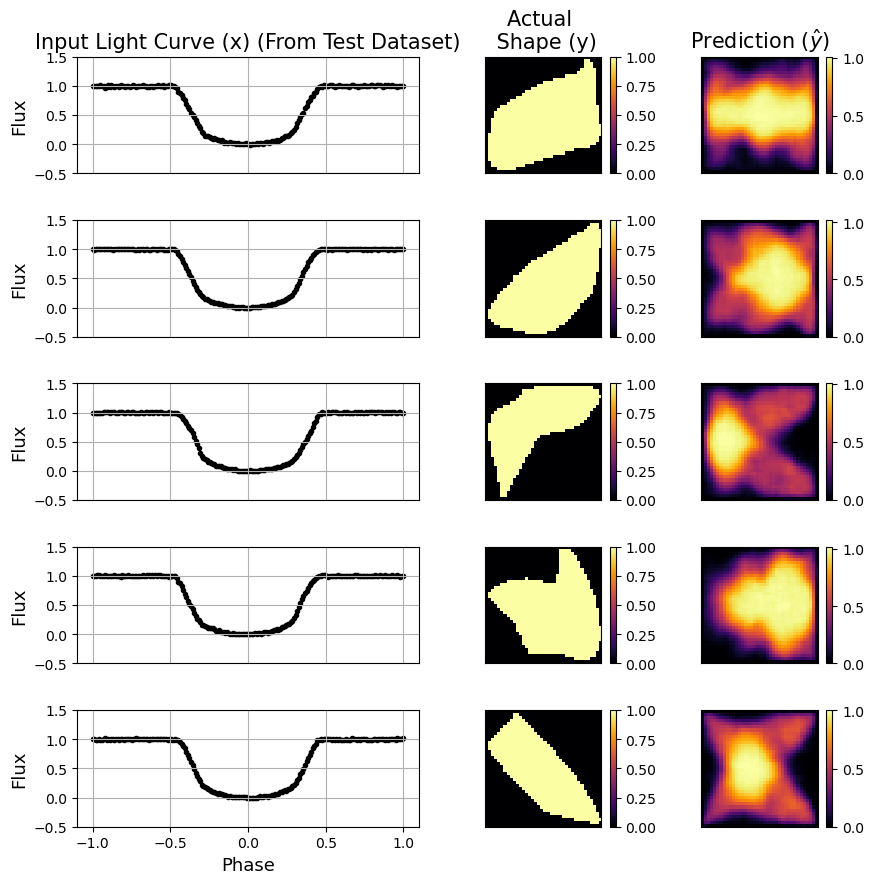

In [27]:
num = 5
fig,ax=plt.subplots(num,3, figsize=(10,10), gridspec_kw={ 'width_ratios': [2,1,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Actual \n Shape (y)',size=15)
ax[0][0].set_title('Input Light Curve (x) (From Test Dataset)',size=15)
ax[0][2].set_title(r'Prediction ($\hat{y}$)',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1.0,1.0,len(test_lc_scaled[0]))
# advance = 60
for i in range(num): 
    k = random.randint(0, len(test_lc_scaled)-1) # 220 + i # 
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(test_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
    ax[i][0].scatter(ph, test_lc_scaled_noise[k],color = 'black',marker='.')
    img = ax[i][2].imshow(test_predict_shape[k],cmap='inferno')
    ax[i][0].grid('on')
    plt.colorbar(img)